In [1]:
# Previous notebook was getting long

In [2]:
# Required imports
import json
import re
import zipfile as zp
import pandas as pd
import numpy as np
import emoji
import random
import pygal
import user_agents
#flask example (example.zip musi być w katalogu głównym)
from util import *

# from user_agents import parse

# # Let's start from an old, non touch Blackberry device
# ua_string = 'BlackBerry9700/5.0.0.862 Profile/MIDP-2.1 Configuration/CLDC-1.1 VendorID/331 UNTRUSTED/1.0 3gpp-gba'
# user_agent = parse(ua_string)
# user_agent.is_mobile # returns True
# user_agent.is_tablet # returns False
# user_agent.is_touch_capable # returns False
# user_agent.is_pc # returns False
# user_agent.is_bot # returns False
# str(user_agent) # returns "BlackBerry 9700 / BlackBerry OS 5 / BlackBerry 9700"


In [3]:
def format_user_agent(t):
    t = user_agents.parse(t)
    dev = str(t.device.brand) + ' ' + str(t.device.model)
    if t.device.brand == None and t.device.model == None:
        if t.is_pc:
            dev = 'PC'
        else:
            dev = 'Other'
    # t.os.family, t.browser.family, dev
    return  dev + ' / ' + str(t.os.family) + ' / ' + t.browser.family

In [4]:
# zip_path = "/home/jacek/Pobrane/Okon_Slowacki_30_11_2020.zip"
zip_path = "/home/jacek/Pobrane/facebook-jacekstasiak75 222.zip"
# zip_path = "/home/jacek/Pobrane/win10 unpacked/facebook-okoń 28-12-20.zip"
# zip_path = "/home/jacek/Pobrane/facebook-janpodkowa98.zip"

data = None
frens = None
logins = None
acc_activity = None
with zp.ZipFile(zip_path) as zip:
    data = gen_pandas_table(zip)

    folders = get_structure(zip)
    fb_activity_path = None
    acc_activity_path = None
    
    for i in folders['security_and_login_information']['__files']:
        if i[0] == 'your_facebook_activity.json':
            fb_activity_path = i[1]
        elif i[0] == 'account_activity.json':
            acc_activity_path = i[1]
    
    log_data = pd.DataFrame()
    with zip.open(fb_activity_path) as f:
        jsec = json.loads(f.read())
        act_type = []
        act_time = []
        for k, v in jsec['last_activity']['last_activity_time'].items():
#             print(k)
            for i in v['activity_by_day']:
                act_type.append(k)
                act_time.append(i)
        log_data = pd.DataFrame({'source': act_type, 'time': act_time})
        log_data.time = pd.to_datetime(log_data.time, unit='s')
    logins = log_data
    
    
    with zip.open(acc_activity_path) as f:
        actions = []
        times = []
        agents = []
        jdata = json.loads(f.read())
        for j in jdata['account_activity']:
#             print(j['action'] + ", " + j['user_agent'])
            actions.append(j['action'])
            parsed_agent = format_user_agent(j['user_agent'])
#             parsed_agent = str(user_agents.parse(j['user_agent']))
#             print(j['user_agent'])
#             if 'Facebook' in parsed_agent:
#                 parsed_agent = re.sub('Facebook.*', 'Facebook', parsed_agent)
                
            agents.append(str(parsed_agent))
            times.append(j['timestamp'])
            
        acc_activity = pd.DataFrame({'time': times, 'agent': agents, 'action': actions})
        acc_activity.time = pd.to_datetime(acc_activity.time, unit='s')
        
#         print(jsec)
# logins
# logins.groupby(logins.source).count()
# messages_table = data['messages']

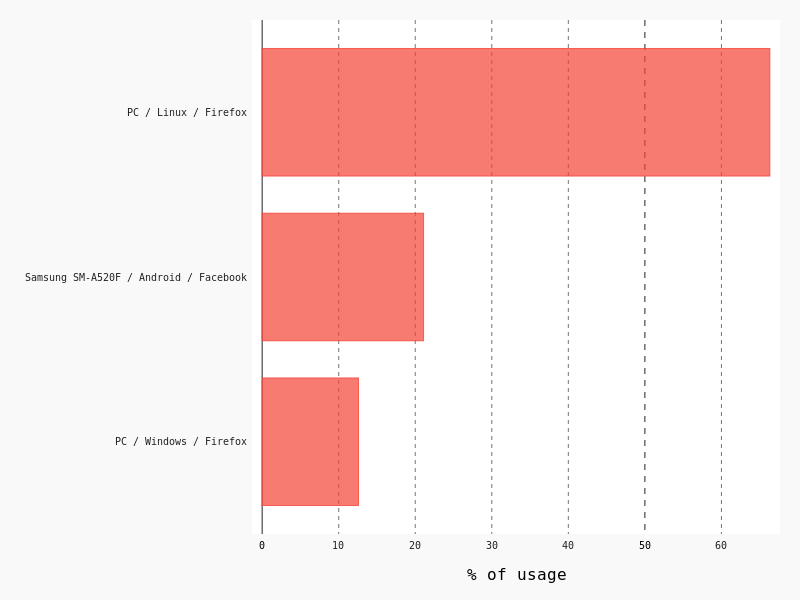

In [14]:
# print(data.keys())
acc_act = data['account_activity']
acc_act.agent.unique()
device_usage = acc_act.groupby(acc_act.agent).action.count().sort_values(ascending=True)
total_uses = device_usage.sum()

chart = pygal.HorizontalBar(show_legend=False)
chart.x_labels = list(device_usage.index)
chart.add('', [ (i / total_uses) * 100 for i in list(device_usage)])
# chart.y_title = 'device name'
chart.x_title = '% of usage'

# hour_active = acc_act[(acc_act.action == 'Login') | (acc_act.action == 'Session updated')].groupby(acc_activity.time.dt.hour)
# hour_active = hour_active.action.count()
# total_hours = hour_active.sum()
# print(total_hours)
# hour_active = dict(hour_active)
# for i in range(24):
#     if not i in hour_active:
#         hour_active[i] = 0
# # sorted(hour_active.items(), key=lambda x: x[0])
# chart = pygal.Bar(show_legend=False)
# chart.x_labels = [i for i in range(24)]
# chart.add('', [(hour_active[i] / total_hours) * 100 for i in range(24)])
# chart.y_title = '% of activity'
# chart.x_title = 'hour'
chart


#20:13

In [ ]:
# change
# * Przeniosłem funkcje związane z wczytywaniem zipa z messages.py do util.py
# * Nowy jupyter notatnik
# * requirements.txt user-agents ?!??

# wczytywanie loginów (później będzie dołączone do gen_pandas_table)
